# Drug Overdose Deaths

There is a crisis plaguing the nation. Between 2020 and 2021 alone, more than 107,000 drug-related deaths were reported in the United States. 
Drawing on data from the last few years, in this project we try to see the following:
- Is there a way to predict potential future drug overdose counts? 

## Why?
This sort of prediction may aid in the development of law and policy that reduces the potential for overdoses on a state-by-state basis, and enlighten non-profit organizations that tackle the drug problem in ensuring their resources are properly allocated to areas with the most dire overdose situations.

Project outline:
https://docs.google.com/document/d/1LIcJZ7wE4de4kj5ljFsxvIerTPgG_UZ3Dm7wy0xBy0M/edit


In [1]:
# helper functions to make the notebook more readable
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

def get_data(location_pair): 
    # Tries to get local version and then defaults to google drive version
    (loc, gdrive)=location_pair
    try:
        out=pd.read_csv(loc)

    except FileNotFoundError:
        print(f"Local file named {loc} not found, downloading from Google Drive...")
        out = download_remote_data(loc, gdrive)
    
    return out

def download_remote_data(file_name, gdrive_file_id):
    "downloads a file from google drive and saves it to local storage as file_name"
    remote_loc = 'https://drive.google.com/uc?export=download&id=' + gdrive_file_id.split('/')[-2]
    out=pd.read_csv(remote_loc)
    print(f"Saving the downloaded file to local storage as {file_name}...")
    out.to_csv(file_name)
    print("... saved.")
    return out 

def drop_colum_with_only_one_unique_value(data):

    # Dropping the columns that have only 1 unique value (no added information from these columns):
    for col in data.columns:
        if len(data[col].unique())==1:
            data.drop(col,axis=1,inplace=True)

    return data

def drug_overdose_data_preprocess(data):
    # Drop unnecessary columns and drop columns with only one unique value
    data.drop(['Footnote',
                'Footnote Symbol', 
                'Percent Pending Investigation',
                'Predicted Value'],
                axis=1,inplace=True)

    data = drop_colum_with_only_one_unique_value(data)
    data.dropna(inplace=True)

    # Drop rows with 'YC' in the 'State' column:
    data = data[data.State != 'YC']

    # we are interested in the data for 2021 only
    data = data[data.Year == 2021]

    # In the 'Indicator' column, we are interested in the rows that have 'Number of Drug Overdose Deaths' in them
    # and we are not interested in the rows that have 'Percent with drugs specified' in them
    data = data[data.Indicator != 'Percent with drugs specified']
    data = data[data.Indicator == 'Number of Drug Overdose Deaths']

    # Drop the 'Indicator' column since we are not interested in it anymore
    data.drop(['Indicator', "Month", "Year", "State"], axis=1, inplace=True)

    # finally get the sum of the drug overdose deaths for each state
    data = data.replace(',','', regex=True)
    data['Data Value'] = data['Data Value'].astype(int)
    data = data.groupby('State Name', as_index=False)['Data Value'].sum()
    data.rename(columns={'Data Value': 'Overdose Deaths'}, inplace=True)

    return data

def final_preprocess(predictors, drug_overdose_data):

    """
    We added more data and summarized the drug overdose deaths. We decided to use data from 2018 since that was easieast and most comprehensive year to obtain data from various data sources.
    Our data now consists of:
    
    *   Tax Rate
    *   List item
    *   Unemployment Rate
    *   Cost of Living Compared to the Average
    *   High School Graduation Rate
    *   GDP Per Capita
    *   Life Expectancy
    *   Average Age
    *   Poverty Rate
    *   Violent Crime Rate
    *   Population
    *   Drug Overdose Deaths

    for all 50 states.
    """


    final_data = predictors.merge(drug_overdose_data).rename(columns={'Data Value': 'Overdose Deaths'})

    # Convert 'GDP Per Capita' and 'Population' from 'Object' type to 'int':
    final_data = final_data.replace(',','', regex=True)
    final_data[['GDP Per Capita', 'Population']] = final_data[['GDP Per Capita', 'Population']].apply(pd.to_numeric)

    # Instead of dropping State Name, convert it to numerical:
    # final_data = final_data.drop(axis=1, labels=['State Name'])

    final_data['State Name'] = pd.Categorical(final_data['State Name'])
    # print(final_data['State Name'].dtypes)
    cat_columns = final_data.select_dtypes(['category']).columns
    final_data[cat_columns] = final_data[cat_columns].apply(lambda x: x.cat.codes)

    # scale the label column "Overdose Deaths" by dividing by 10000:
    final_data["Overdose Deaths"] = final_data["Overdose Deaths"]/10000
    final_data = final_data.rename({'Overdose Deaths': 'Overdose Deaths e10-4'}, axis=1)
    try: final_data.drop(['Unnamed: 0'], axis=1, inplace=True) 
    except: pass
    return final_data

def visualize_correlation(data):
    """
    Scatterplot Visualization
    Here we visualize the correlation in a scatterplot to better see the data.
    """
    sns.set_palette('colorblind')
    sns.pairplot(data=data, height=3)

def get_dataframe(data_file_name, use_pickle=True, safe_pickle=True):
    
    if use_pickle:
        data_pickle_file_name = data_file_name
    else: 
        data_pickle_file_name = "" # this condition forces the function into exception handling.
    
    try:
        data = pd.read_pickle(data_pickle_file_name)
        print("Dataframe loaded from pickle file.")

    except FileNotFoundError:
        print("Dataframe pickle file not found, creating dataframe and pickling the file for future use...")

        local_file_name = 'VSRR_Provisional_Drug_Overdose_Death_Counts.csv'
        remote_file_name = 'https://drive.google.com/file/d/1ah5KesrTEmAKraaZM4HSPRhWMihc36gS/view?usp=sharing'

        drug_overdose_data = drug_overdose_data_preprocess(get_data((local_file_name, remote_file_name)))
        
        local_file_name = '2018predictors.csv'
        remote_file_name = 'https://drive.google.com/file/d/1WEDm7_xasrjbV6WsWw773Q1eWa5qaWMU/view?usp=sharing'

        data = final_preprocess(get_data((local_file_name, remote_file_name)), drug_overdose_data)
        if safe_pickle: 
            data.to_pickle(data_file_name)
            print(f"saved pickel file as {data_file_name}.")

    return data


class NeuralNetwork(nn.Module):
        def __init__(self, X_input_dim):
            super(NeuralNetwork, self).__init__()
            self.layer1 = nn.Linear(X_input_dim, 32) # input: X.shape[1]=13, output: 32
            self.layer2 = nn.Linear(32, 32)
            self.layer3 = nn.Linear(32, 16)
            self.layer4 = nn.Linear(16, 1)

        def forward(self, x):
            x = F.relu( self.layer1(x) )
            x = F.relu( self.layer2(x) )
            x = F.relu( self.layer3(x) )
            x = self.layer4(x)

            return x

def train_step(x, y, nnmodel, loss_function, optimizer):
  # initialize the gradient of model parameters
  optimizer.zero_grad()
  # make prediction
  y_val = nnmodel(x)
  # calculate the loss
  loss = loss_function(y_val, y)
  # Backpropagation
  loss.backward()
  # Update parameters
  optimizer.step()
  
  return loss.item()

def train(x, y, nnmodel, loss_function, optimizer, epochs=20, print_iter_freq=20, batch=7):
  # Setup Mini-Batch Learning:
  
  # Wrap x_train and y_train in a TensorDataset object
  train_data = TensorDataset(x, y)
  # Create DataLoader with batch_size
  train_loader = DataLoader(dataset=train_data, batch_size=batch, shuffle=True)
  # print(next(iter(train_loader)))

  losses = []
  # Epochs iterations
  for i in range(epochs):
    for x_batch, y_batch in train_loader:  
      loss = train_step(x_batch, y_batch, nnmodel, loss_function, optimizer)
      losses.append(loss)
    
    # loss = train_step(x_train, y_train, model=model, loss_function=mse_loss, optimizer=sgd_optimizer)
    # # losses.append(loss.detach().numpy())
    # losses.append(loss)

    if (i % print_iter_freq) == 0:
      print('epoch: {},'.format(i) + 'loss: {:.5f}'.format(loss))

  return losses

def visualizer(loss):
  plt.figure()
  plt.plot(loss,color="red")
  plt.xlabel("Iteration")
  plt.ylabel("loss")
  plt.ylim = ((0,50))
  plt.xlim = ((0,2000))
  title=[]
  title.append("Losses")
  plt.title("\n".join(title))
  plt.axhline(0,linewidth=2,linestyle=":",color="black")
  plt.show()
  plt.close()

# Data gathering and Processing
We first gather our data, process it, and then pickle the dataframe object to safe on computation. get_dataframe() function handles the formentioned task.

After preprocessing our data then consists of:

- Tax Rate
- List item
- Unemployment Rate
- Cost of Living Compared to the Average
- High School Graduation Rate
- GDP Per Capita
- Life Expectancy
- Average Age
- Poverty Rate
- Violent Crime Rate
- Population
- Drug Overdose Deaths

for all 50 states.

In [2]:

data = get_dataframe('data.pickle', use_pickle=True)
data.head()

Dataframe loaded from pickle file.


,State Name,Tax Rate,Unemployment Rate,Cost Of Living,Average Temperature,High School Graduation Rate,GDP Per Capita,Life Expectancy,Average Age,Poverty Rate,Violent Crime Rate,Population,Overdose Deaths e10-4
0,0,7.28,3.9,1.15,62.8,85.3,37261,75.4,38.9,19.2,8.3,4891628,1.4096
1,1,5.10,6.6,0.95,26.6,92.4,63971,78.3,34.5,11.4,8.4,736624,0.2416
2,2,8.26,4.8,1.04,60.3,86.5,38590,79.6,37.7,18.2,5.9,7164228,3.2656
3,3,9.11,3.7,1.14,60.4,85.6,36368,76.0,38.1,18.7,8.6,3012161,0.6775
4,4,9.47,4.2,0.88,59.4,79.5,53987,80.8,36.5,16.4,4.6,39437463,12.8028


# Visualization of data
once we have the data preprocessed, we visualize the corelation to better understand the data.

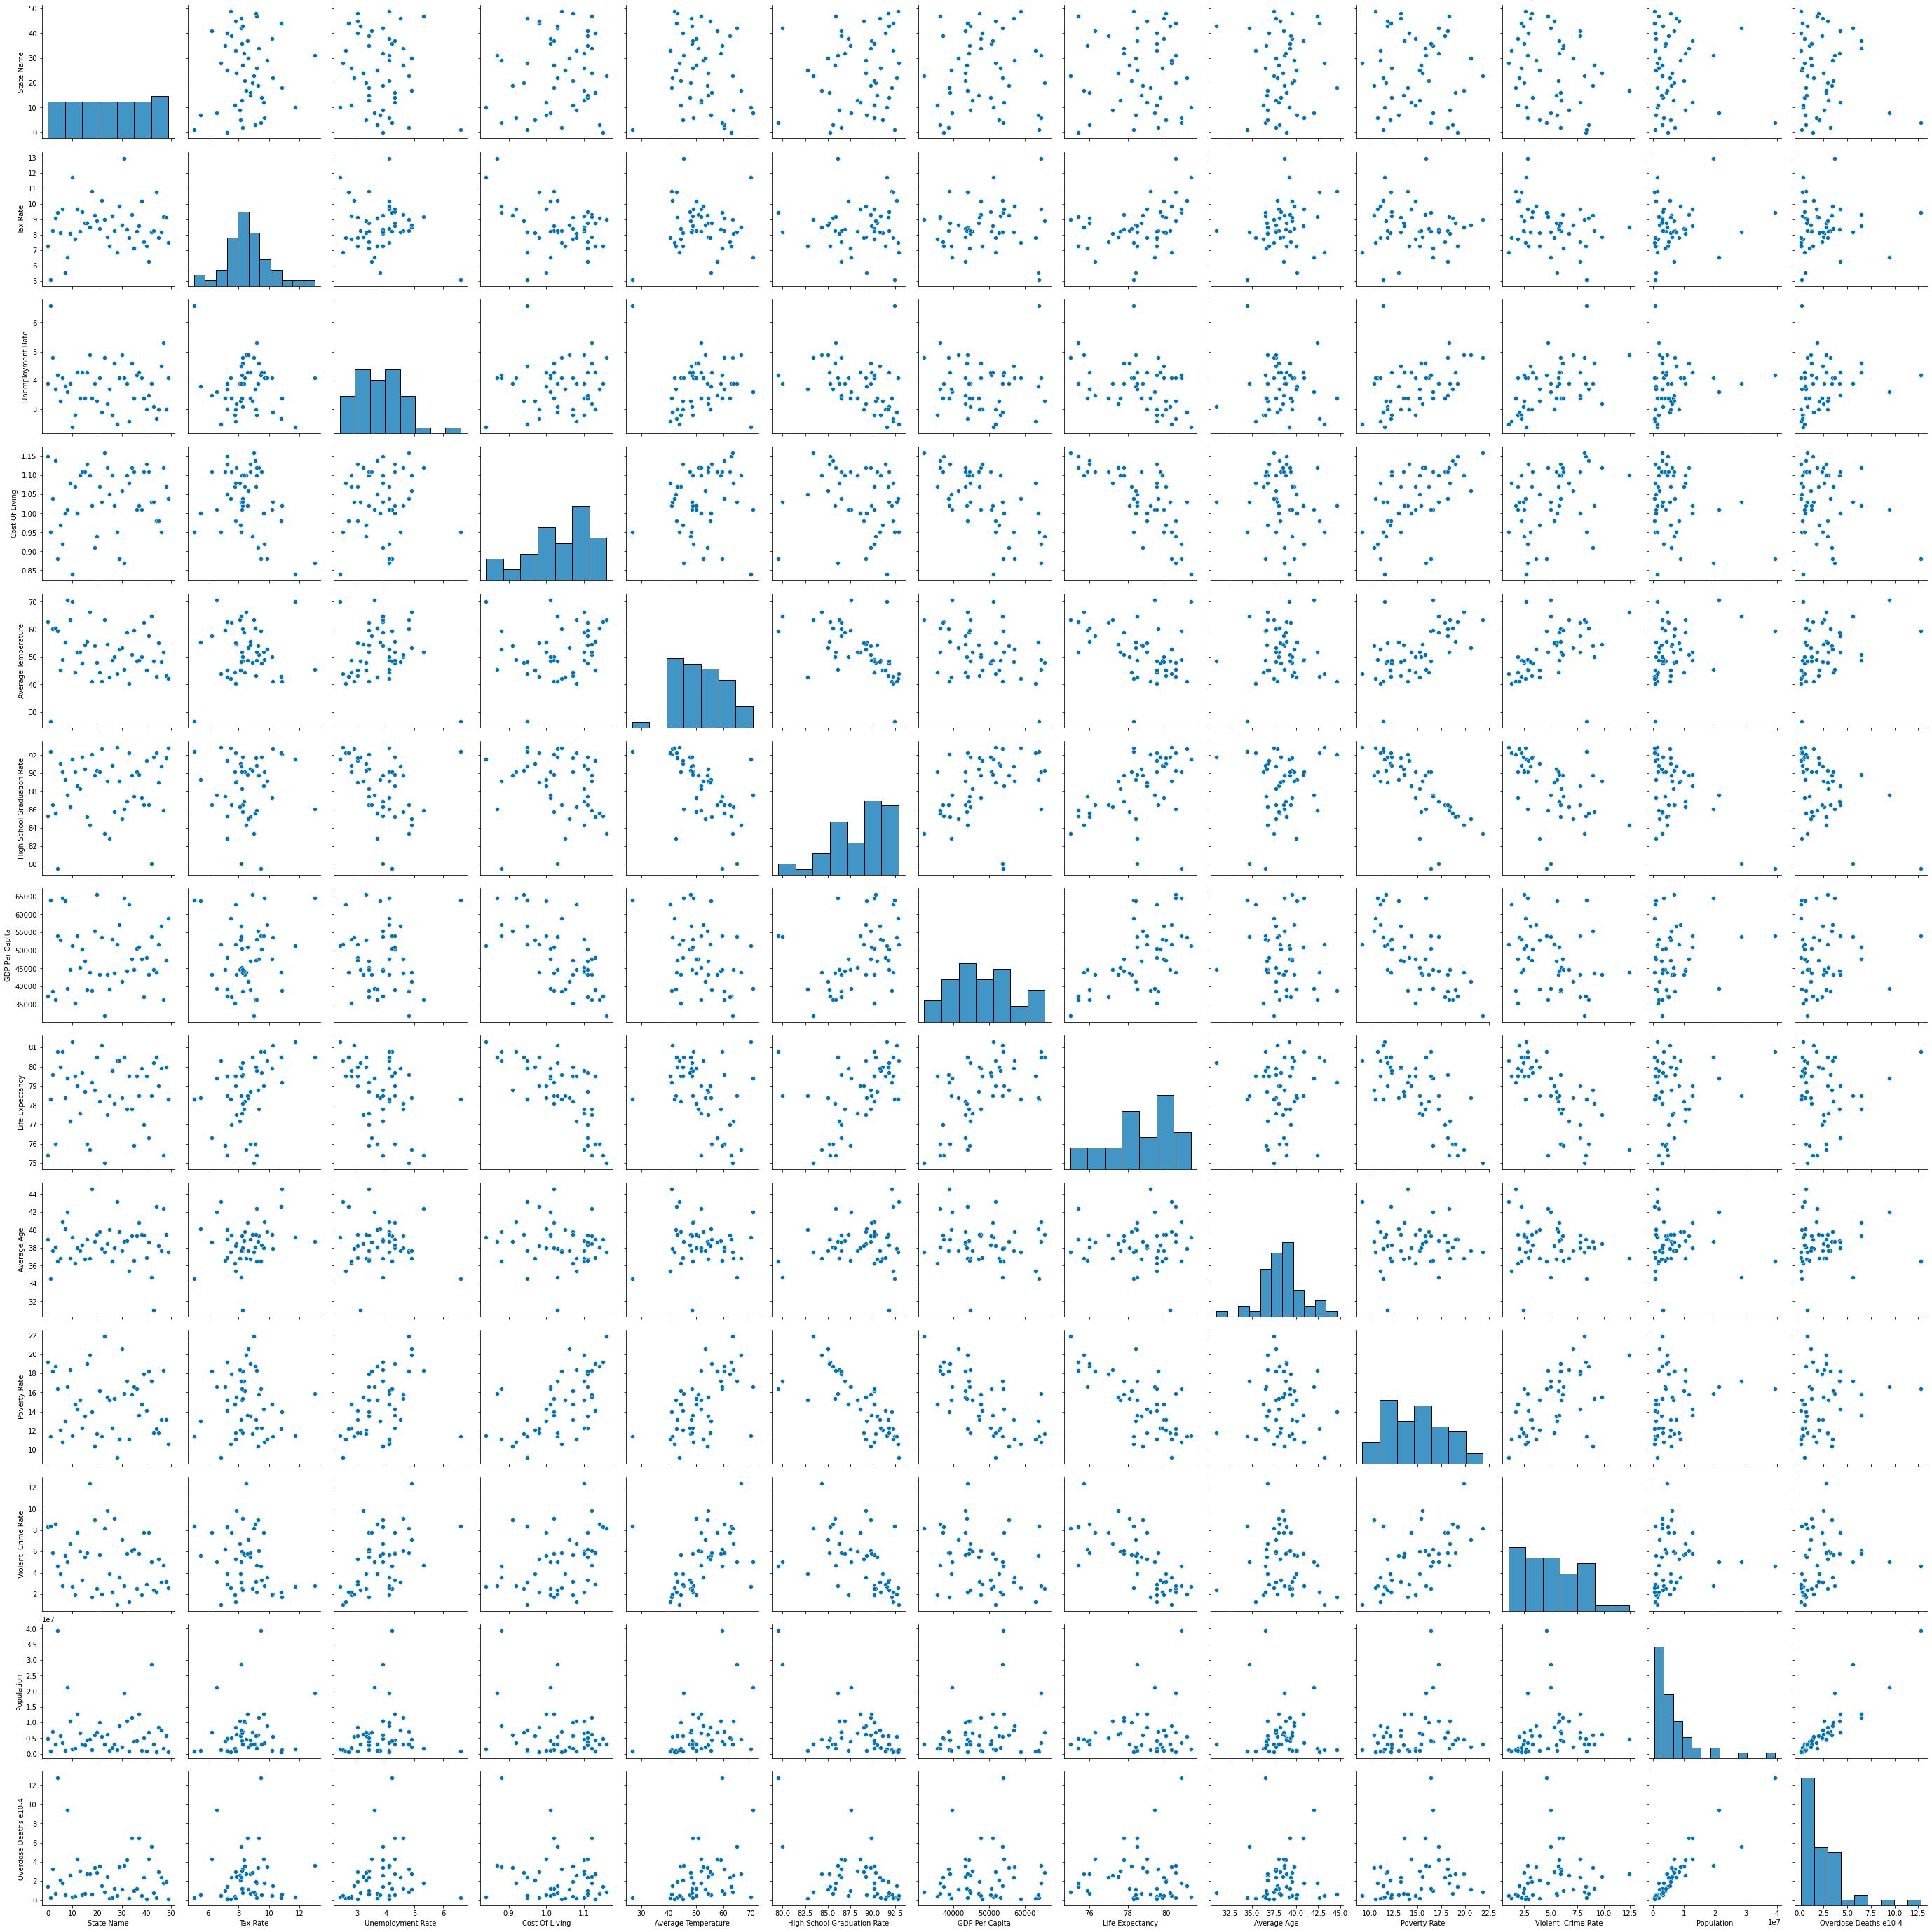

In [3]:
"""Using a correlation matrix to see how the various predictors compare to eachother and the overose deaths."""
visualize_correlation(data)

## Linear Regression
Building a simple miltilinear regression for referance purposes. 


### Standardizing the Data (Z-Score) and splitting the training and test dataset

In [4]:
y = data['Overdose Deaths e10-4']
x = data.drop(axis=1, labels=['Overdose Deaths e10-4'])

sscaler = preprocessing.StandardScaler()
sscaler.fit(x)
x_std = sscaler.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size = 0.2, random_state = 100)

### Fitting the Multilinear Regression Model and seeing how well our model fits the data.

In [5]:
LR = LinearRegression()
LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)
score=r2_score(y_test,y_prediction)
print('r^2=', score)
print('Mean Squared Error=', mean_squared_error(y_test,y_prediction))
print('Root Mean Squared Error=', np.sqrt(mean_squared_error(y_test,y_prediction)))

r^2= 0.5069193236099938
Mean Squared Error= 2.2151608031651615
Root Mean Squared Error= 1.4883416285131454


## Deep learning model
Here we will construct a deep neural network to predict the Overdose Death rate in all 50 states.

#### Convert our test and train data into tensor

In [6]:
x_train = torch.tensor(np.array(x_train), dtype=torch.float)
y_train = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float)

x_test = torch.tensor(np.array(x_test), dtype=torch.float)
y_test = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float)

#### A class to contain our experiment

In [7]:

class Experiment:
    def __init__(self, input_size, optimizer, lr, epochs, batch, loss_function=nn.MSELoss()) -> None:
        self.model = NeuralNetwork(input_size)
        self.optimizer = optimizer(self.model.parameters(), lr)
        self.lr = lr
        self.epochs = epochs
        self.batch = batch
        self.loss_function = loss_function
        self.training_losses = None


    def train(self, x, y):
        self.training_losses =  train(x, y, self.model, self.loss_function, self.optimizer, self.epochs, batch=self.batch, print_iter_freq=self.epochs//3)
        return self.training_losses
    
    @property
    def losses(self):
        return self.training_losses
        
    def predict(self, x):
        return self.model(x)
    
    def __str__(self) -> str:
        return f"Optimizer={self.optimizer} lr={self.lr}, epochs={self.epochs}, batch={self.batch}"
    

#### Defining experiments

In [8]:

nn_input = x_train.shape[1]
experiments = [
    Experiment(nn_input, optim.SGD, 0.0001, 2000, 7),
    Experiment(nn_input, optim.Adam, 0.0001, 2000, 7),
    Experiment(nn_input, optim.Adagrad, 0.0001, 2000, 7),
    
    Experiment(nn_input, optim.SGD, 0.000001, 2000, 7),
    Experiment(nn_input, optim.Adam, 0.000001, 2000, 7),
    Experiment(nn_input, optim.Adagrad, 0.000001, 2000, 7),
    
    Experiment(nn_input, optim.SGD, 1e-3, 2000, 7),
    Experiment(nn_input, optim.Adam, 1e-3, 2000, 7),
    
    Experiment(nn_input, optim.SGD, 1e-5, 2000, 16),
    Experiment(nn_input, optim.Adam, 1e-5, 2000, 16),
    Experiment(nn_input, optim.SGD, 1e-6, 2000, 16),
]

#### Training models

In [9]:
for count, experiment in enumerate(experiments):
    print(f"Training model #{count} ...")
    losses = experiment.train(x_train, y_train)
    print("training complete \n")

print("************** Experiment Complete **************")

Training model #0 ...
epoch: 0,loss: 37.81070
epoch: 666,loss: 7.36529
epoch: 1332,loss: 0.37918
epoch: 1998,loss: 0.32723
training complete 

Training model #1 ...
epoch: 0,loss: 23.68864
epoch: 666,loss: 0.02139
epoch: 1332,loss: 0.00400
epoch: 1998,loss: 0.00000
training complete 

Training model #2 ...
epoch: 0,loss: 40.91672
epoch: 666,loss: 41.36061
epoch: 1332,loss: 19.61173
epoch: 1998,loss: 37.27219
training complete 

Training model #3 ...
epoch: 0,loss: 24.05971
epoch: 666,loss: 1.95483
epoch: 1332,loss: 6.35968
epoch: 1998,loss: 5.13154
training complete 

Training model #4 ...
epoch: 0,loss: 22.53757
epoch: 666,loss: 36.21180
epoch: 1332,loss: 3.84100
epoch: 1998,loss: 9.18673
training complete 

Training model #5 ...
epoch: 0,loss: 5.04027
epoch: 666,loss: 3.41772
epoch: 1332,loss: 13.52465
epoch: 1998,loss: 6.40983
training complete 

Training model #6 ...
epoch: 0,loss: 7.54908
epoch: 666,loss: 0.01949
epoch: 1332,loss: 0.01437
epoch: 1998,loss: 0.00210
training complet

#### Testing model

In [10]:

r2 = []
for experiment in experiments:
    Y_val_pred1 = experiment.predict(x_test)
    # Convert into numpy array
    Y_val_pred1 = Y_val_pred1.detach().numpy()
    R2 = r2_score(y_test, Y_val_pred1)
    r2.append(R2)

print(r2)

[0.36177129600736013, 0.30309913905647823, -0.8686676575020769, -0.7758463501484136, -1.0387604567893374, -0.9079787040920044, 0.6372534744930771, 0.6442698617890916, -0.5145305016117137, -0.49973793010070366, -1.39886137328245]


#### Picking the best model

In [11]:
# R^2 = 1 is the best case sensrio, we are trying to find the model that is the closest to 1 
def find_best_model(experiments):
    min_diff = 10000000000000000000000000000000000000000
    best_model = None
    best_r2 = None
    for count, r in enumerate(r2):
        diff = abs(r - 1)
        if diff < min_diff:
            min_diff = diff
            best_r2 = r
            best_model = experiments[count]
    return best_r2, best_model

best_r2, best_model = find_best_model(experiments)

print(best_r2)
print(best_model)


0.6442698617890916
Optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
) lr=0.001, epochs=2000, batch=7


#### Visualization

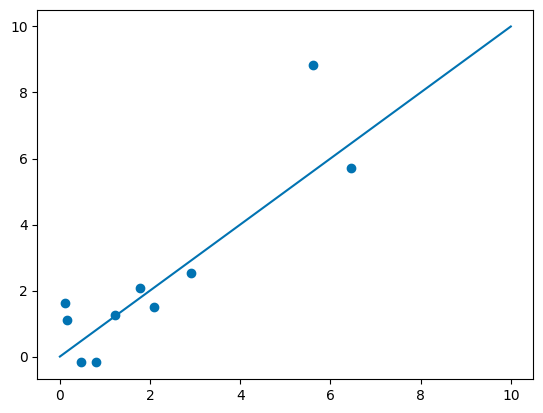

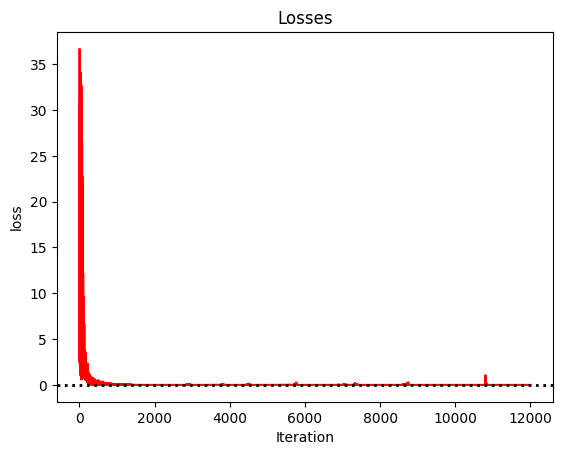

In [12]:
Y_test_pred =  best_model.predict(x_test)
Y_test_pred = Y_test_pred.detach().numpy()
R2 = r2_score(y_test, Y_test_pred)

plt.xlim = ((0,10))
plt.ylim = ((0,10))
plt.scatter(y_test,Y_test_pred)
plt.plot([0,10],[0,10])

visualizer(best_model.losses)